notebook to plot boundary conditions from `NT_BC` and compare to Geant simulations

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
def plottable(X, Y):
    return (X[1:] + X[:-1])/2, Y[1:]

def plottable_spectrum(X, Y):
    return (X[1:] + X[:-1])/2, Y[1:]/abs(X[1:] - X[:-1])

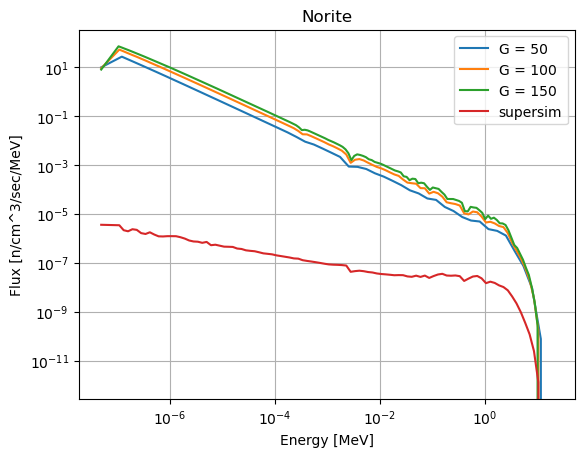

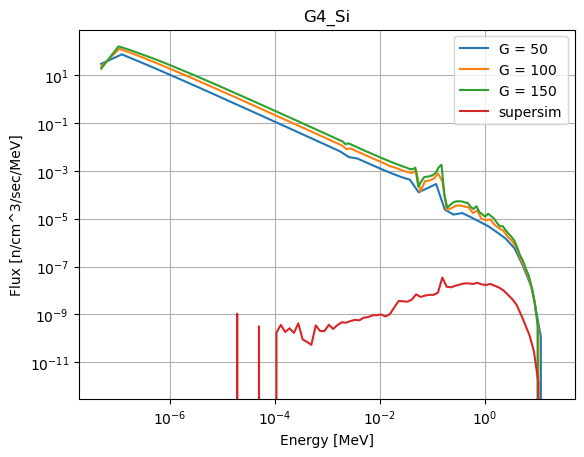

In [12]:
for mat in ['Norite', 'G4_Si']:

    mat_str_add = '_Si' if mat == 'G4_Si' else ''

    ss_data_file = 'data/SuperSim_estimates/phi_calcs' + mat_str_add + '.dat'
    ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig'])

    Eg_s = ss_dat.Eg.values
    phig_s = ss_dat.phig.values
    gs_s = ss_dat.index

    plt.figure()
    plt.loglog()
    plt.grid()
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Flux [n/cm^2/sec/MeV]')
    plt.title(mat)

    for G in [50, 100, 150]:
        data_file = f'data/V1/data_{mat}_{G}_BC_V1.dat'
        dat = pd.read_csv(data_file, sep = ' ', index_col = 0, names = ['Eg','phig'])

        Eg = dat.Eg.values
        phig = dat.phig.values
        gs = dat.index

        plt.plot(*plottable_spectrum(Eg, phig), label = f'G = {G}')
    plt.plot(*plottable_spectrum(Eg_s, phig_s), label = 'supersim')
    #plt.plot(Eg[:-1], (1e-11)/Eg[:-1], label = '1/E')

    plt.legend()

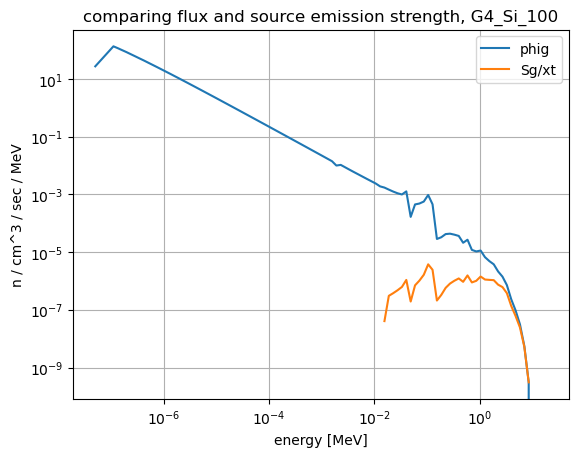

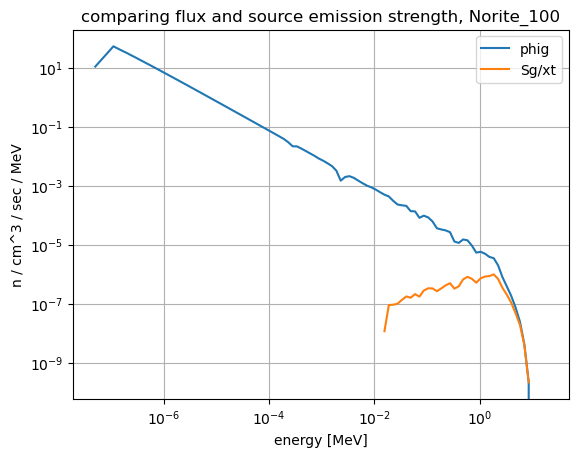

In [17]:
# compare flux and emission strength (group source/group total cross section)

for mat, G in [('G4_Si', 100), ('Norite', 100)]:

    XS = pd.read_csv(f'../cross_sections/data/V1/data_{mat}_{G}_20_xs.dat', sep = ' ', index_col = 0, names = ['Eg', 'x_s', 'xt'])
    Src = pd.read_csv(f'../sources/data/V1/data_{mat}_{G}_Sg.dat', sep = ' ', index_col = 0, names = ['Eg','Sg'])
    BC = pd.read_csv(f'../boundary_conditions/data/V1/data_{mat}_{G}_BC_V1.dat', sep = ' ', index_col = 0, names = ['Eg','phig'])

    Eg = BC.Eg.values
    Es = (Eg[1:] + Eg[:-1])/2
    dE = abs(Eg[1:] - Eg[:-1])

    phig = BC.phig.values[:-1]/dE
    Sg = Src.Sg.values[:-1]/dE
    xt = XS.xt.values[:-1]
    xs = XS.x_s.values[:-1]

    p2 = Sg!=0

    plt.figure()
    plt.loglog()
    plt.grid()
    plt.xlabel('energy [MeV]')
    plt.ylabel('n / cm^2 / sec / MeV')
    plt.title(f'comparing flux and source emission strength, {mat}_{G}')

    plt.plot(Es, phig, label = 'phig')
    plt.plot(Es[p2], Sg[p2]/xt[p2], label = 'Sg/xt')


    plt.legend()

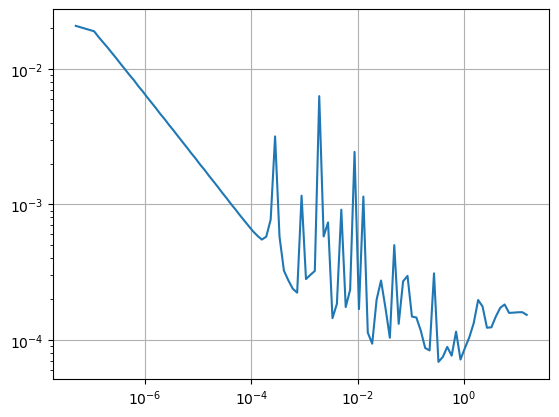

In [14]:
plt.figure()
plt.loglog()
plt.grid()
plt.plot(Es[xt>0], (xt-xs)[xt>0]/xt[xt>0])